# Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandarallel import pandarallel
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from textblob import TextBlob
from os.path import exists

# Initialize Pandarallel
pandarallel.initialize(progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


# Loading the Files

Download the csv files into the `data/` directory.

Train data shape: (1697533, 9)
Test data shape: (212192, 2)

        Id   ProductId          UserId  HelpfulnessNumerator  \
0   914403  B0009W5KHM   AV6QDP8Q0ONK4                     2   
1   354887  6303079709  A2I8RXJN80A2D2                     0   
2  1407653  B004H0M2XC  A3FHV3RV8Z12E6                     0   
3  1377458  B003ZJ9536  A12VLTA3ZHVPUY                     1   
4   475323  630574453X  A13NM1PES9OXVN                     2   

   HelpfulnessDenominator        Time  \
0                       2  1341014400   
1                       0  1168819200   
2                       0  1386201600   
3                       1  1348704000   
4                       3   970012800   

                                         Summary  \
0                                  GOOD FUN FILM   
1                                   Movie Review   
2             When is it a good time to Consent?   
3                                          TRUTH   
4  Intelligent and bittersweet -- stays with yo

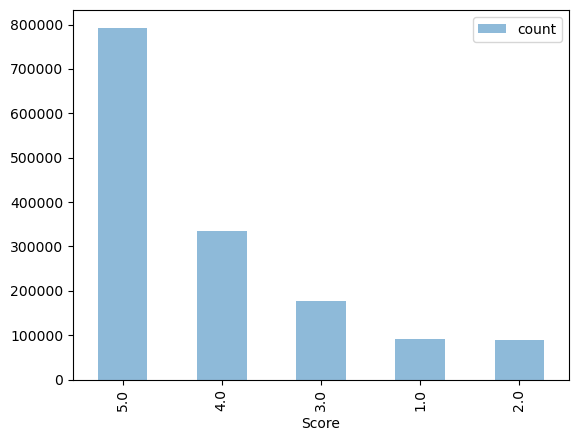


EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print()

print(train_data.head())
print()
print(test_data.head())
print()

print(train_data.describe())

# Visualize the distribution of 'Score'
train_data['Score'].value_counts().plot(kind='bar', legend=True, alpha=.5)
plt.show()
print()
print("EVERYTHING IS PROPERLY SET UP! YOU ARE READY TO START")

# Adding Features

In [3]:
def add_features_to(df, training_data=None):
    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)
    df['IsHelpful'] = (df['HelpfulnessNumerator'] > 0).astype(int)
    df['HelpfulnessDifference'] = df['HelpfulnessNumerator'] - df['HelpfulnessDenominator']
    df['WeightedHelpfulness'] = df['HelpfulnessNumerator'] / (df['HelpfulnessDenominator'] + 1)
    time_series = pd.to_datetime(df['Time'], unit='s')
    df['Year'] = time_series.dt.year
    df['Month'] = time_series.dt.month
    df['DayOfWeek'] = time_series.dt.dayofweek
    df['Quarter'] = time_series.dt.quarter
    
    # User and Product history features
    if training_data is not None:
        user_means = training_data.groupby('UserId')['Score'].mean()
        product_means = training_data.groupby('ProductId')['Score'].mean()
        global_mean = training_data['Score'].mean()
    else:
        user_means = df.groupby('UserId')['Score'].mean()
        product_means = df.groupby('ProductId')['Score'].mean()
        global_mean = df['Score'].mean()
    
    df['UserMeanScore'] = df['UserId'].map(user_means)
    df['ProductMeanScore'] = df['ProductId'].map(product_means)
    df['UserMedianScore'] = df['UserId'].map(training_data.groupby('UserId')['Score'].median() if training_data is not None else df.groupby('UserId')['Score'].median())
    df['UserReviewCount'] = df['UserId'].map(training_data.groupby('UserId')['Score'].count() if training_data is not None else df.groupby('UserId')['Score'].count()).fillna(0)
    
    # Fill missing values with global mean
    df['UserMeanScore'] = df['UserMeanScore'].fillna(global_mean)
    df['ProductMeanScore'] = df['ProductMeanScore'].fillna(global_mean)
    
    # Interaction term
    df['UserProductInteraction'] = df['UserMeanScore'] * df['ProductMeanScore']
    
    # Parallelized text-based features
    df['Text'] = df['Text'].fillna("").astype(str)  # Ensure all text fields are strings
    df['ReviewLength'] = df['Text'].parallel_apply(lambda x: len(x.split()))
    df['UniqueWords'] = df['Text'].parallel_apply(lambda x: len(set(x.split())))
    df['AverageWordLength'] = df['Text'].parallel_apply(lambda x: np.mean([len(word) for word in x.split()]) if x.split() else 0)
    df['Sentiment'] = df['Text'].parallel_apply(lambda x: TextBlob(x).sentiment.polarity)
    
    return df

# Cell 6: Apply Feature Engineering to Data
if exists('X_train.csv'):
    X_train = pd.read_csv("X_train.csv")
    X_submission = pd.read_csv("X_submission.csv")
else:
    train = add_features_to(train_data)
    X_submission = pd.merge(train, test_data, left_on='Id', right_on='Id').drop(columns=['Score_x']).rename(columns={'Score_y': 'Score'})
    X_submission = add_features_to(X_submission, train_data)
    X_train = train[train['Score'].notnull()]
    X_submission.to_csv("X_submission.csv", index=False)
    X_train.to_csv("X_train.csv", index=False)

# Sample + Split into training and testing set

In [4]:
from sklearn.model_selection import train_test_split

X = X_train.drop(columns=['Score'])
Y = X_train['Score']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=0)

print(f"Training Set Shape: X_train: {X_train.shape}, Y_train: {Y_train.shape}")
print(f"Testing Set Shape: X_test: {X_test.shape}, Y_test: {Y_test.shape}")


Training Set Shape: X_train: (1114005, 25), Y_train: (1114005,)
Testing Set Shape: X_test: (371336, 25), Y_test: (371336,)


# Feature Selection

In [5]:
# Define other selected features
features = [
    'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Helpfulness', 'IsHelpful', 
    'HelpfulnessDifference', 'WeightedHelpfulness', 'Year', 'Month', 'DayOfWeek', 
    'Quarter', 'UserMeanScore', 'ProductMeanScore', 'UserReviewCount', 
    'UserProductInteraction', 'ReviewLength', 'UniqueWords', 'AverageWordLength', 'Sentiment'
]

# Select features for each dataset
X_train_select = X_train[features]
X_test_select = X_test[features]
X_submission_select = X_submission[features]

# Model Creation

In [10]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Initialize and train the model with all cores
model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.3, random_state=42)
model.fit(X_train_select, Y_train)

# Predict and evaluate
Y_test_predictions = model.predict(X_test_select)
print("Accuracy on testing set =", accuracy_score(Y_test, Y_test_predictions))

Accuracy on testing set = 0.6291256436219489


# Model Evaluation

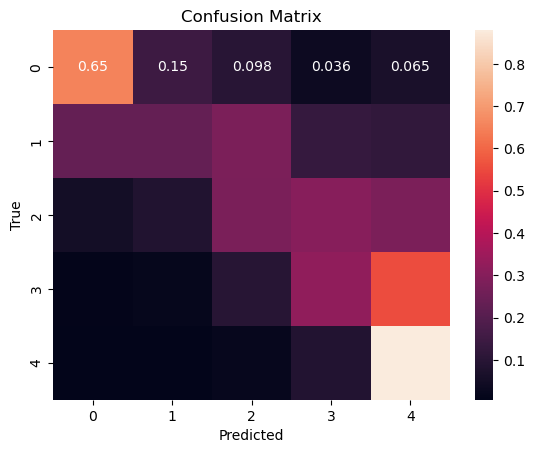

In [11]:
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Create submission file

In [12]:
X_submission['Score'] = model.predict(X_submission_select)
submission = X_submission[['Id', 'Score']]
submission.to_csv("submission.csv", index=False)
print("Submission file created: 'submission.csv'")

Submission file created: 'submission.csv'
